# Check failure cases to see which fail to parameterize and why

First, we import several molecules, define global variables, and create a helper function to check for parametrization failures.

In [1]:
from openforcefield.topology import Molecule, Topology
from openforcefield.typing.engines.smirnoff import (ForceField, 
UnassignedValenceParameterException, BondHandler, AngleHandler,
ProperTorsionHandler, ImproperTorsionHandler,
vdWHandler)
from simtk import unit
import numpy as np
from rdkit import Chem
from rdkit.Chem import Draw, AllChem
#from rdkit.Chem.Draw import rdMolDraw2D
#from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules
from IPython.display import display

# Define "super generics", which are parameters that will match
# each instance of a valence type, such that parametrization
# will not raise a "missing parameter" error when they are defined.
super_generics = {'Bonds': 
                   BondHandler.BondType(smirks='[*:1]~[*:2]', 
                                       k=0*unit.kilocalorie/unit.mole/unit.angstrom**2,
                                       length=0*unit.angstrom
                                       ),
                 'Angles': 
                   AngleHandler.AngleType(smirks='[*:1]~[*:2]~[*:3]',
                                          angle=0*unit.degree,
                                          k=0*unit.kilocalorie/unit.mole/unit.degree**2
                                          ),
                 'ProperTorsions': 
                   ProperTorsionHandler.ProperTorsionType(smirks='[*:1]~[*:2]~[*:3]~[*:4]',
                                                          phase1=0*unit.degree,
                                                          periodicity1=0,
                                                          k1=0*unit.kilocalorie/unit.mole,
                                                          idivf1=1
                                                         ),
                 'ImproperTorsions': 
                   ImproperTorsionHandler.ImproperTorsionType(smirks='[*:1]~[*:2](~[*:3])~[*:4]',
                                                              phase1=0*unit.degree,
                                                              periodicity1=0,
                                                              k1=0*unit.kilocalorie/unit.mole,
                                                              idivf1=1
                                                              ),
                 'vdW': 
                   vdWHandler.vdWType(smirks='[*:1]',
                                      rmin_half=0*unit.angstrom,
                                      epsilon = 0*unit.kilocalorie/unit.mole
                                     ),
                 }

Unable to load toolkit <openforcefield.utils.toolkits.OpenEyeToolkitWrapper object at 0x114443400>.


In [2]:
def report_missing_parameters(molecule, forcefield):
    """
    Analyze a molecule using a provided ForceField, generating a report of any
    chemical groups in the molecule that are lacking parameters.
    
    Parameters
    ----------
    molecule : an openforcefield.topology.FrozenMolecule
        The molecule to analyze
    forcefield : an openforcefield.typing.engine.smirnoff.ForceField
        The ForceField object to use
        
    Returns
    -------
    missing_parameters : dict[tagname: list[dict[tagged_smiles:string, image:PIL.Image, atom indices:list[int]]]]
        A hierarchical dictionary, with first level keys indicating ForceField tag 
        names (eg. "Bonds"), and first-level values which are lists of dictionaries. 
        Each dictionary in this list reflects one missing parameter, and contains the 
        following key:value pairs :
        * "image": PIL.Image 
            * shows a 2D drawing, highlighting the feature that could not be parametrized
        * "tagged_smiles": string
            * SMILES of the whole molecule, tagging the atom indices which could not be
              parametrized
        * "atom_indices": tuple(int)
            * The indices of atoms which could not be parametrized
    
    """
    from copy import deepcopy
    bright_purple_rgb = (0.75, 0.25, 0.75)
        

    # Make deepcopies of both inputs, since we may modify them in this function
    forcefield = deepcopy(forcefield)
    molecule = deepcopy(molecule)
    
    # Set partial charges to placeholder values so that we can skip AM1-BCC during parameterization
    molecule.partial_charges = (np.zeros(molecule.n_atoms) + 0.1) * unit.elementary_charge

    # Prepare dictionary to catch parameterization failure info
    success = False
    missing_params = {}

    while not(success):
        # Try to parameterize the system, catching the exception if there is one.
        try:
            forcefield.create_openmm_system(molecule.to_topology(), 
                                    charge_from_molecules=[molecule])
            success = True
        except UnassignedValenceParameterException as e:      
            success = False

            # Ensure that there is a list initialized for missing parameters under this tagname
            handler_tagname = e.handler_class._TAGNAME
            if handler_tagname not in missing_params:
                missing_params[handler_tagname] = []

            # Create a shortcut to the topology atom tuples attached to the parametrization error
            top_atom_tuples =  e.unassigned_topology_atom_tuples
    
            # Make a summary of the missing parameters from this attempt and add it to 
            # the missing_params dict
            rdmol = molecule.to_rdkit()
            for top_atom_tuple in top_atom_tuples:
                atom_indices = [i.topology_atom_index for i in top_atom_tuple]
                
                # Produce tagged SMILES, using a copy of the RDMol so that 
                # tags aren't attached to the original
                this_rdmol = deepcopy(rdmol)
                this_rdmol.Compute2DCoords()
                for tag_idx, i in enumerate(atom_indices):
                    rdatom = this_rdmol.GetAtomWithIdx(i)
                    rdatom.SetAtomMapNum(tag_idx+1)
                tagged_smiles = Chem.MolToSmiles(this_rdmol)
                
                # Create a 2D drawing of the molecule, highlighting the parametrization failure
                high_atom_map = {i:bright_purple_rgb for i in atom_indices}
                image = Draw.MolToImage(this_rdmol, highlightMap=high_atom_map)

                # Structure and append the relevant info to the missing_params dictionary
                param_description = {'atom_indices': atom_indices,
                                     'image': image, 
                                     'tagged_smiles': tagged_smiles
                                    }
                missing_params[handler_tagname].append(param_description)

            # Add a "super generic" parameter to the top of this handler's ParameterList, 
            # which will make it always find parameters for each term. This will prevent the same
            # parameterization exception from being raised in the next attempt.
            param_list = forcefield.get_parameter_handler(handler_tagname).parameters
            param_list.insert(0, super_generics[handler_tagname])
            
    return missing_params




There are several ways to load molecules into the Open Force Field Toolkit. Below, we show how to load molecule databases from a `.smi`, an `.sdf`, and  `.mol2`. 

_Note that loading `.mol2` files is currently only supported using the OpenEye toolkit._

### Option 1: Load a SMILES dataset

In [3]:
#molecules =  Molecule.from_file('example_smiles.smi', allow_undefined_stereo=True)
molecules =  Molecule.from_file('problem_smiles.smi', allow_undefined_stereo=True)
print(f'Loaded {len(molecules)} molecules')

RDKit WARNING: [19:38:42] WARNING: no name column found on line 0
RDKit WARNING: [19:38:42] WARNING: no name column found on line 1
RDKit WARNING: [19:38:42] WARNING: no name column found on line 2
RDKit WARNING: [19:38:42] WARNING: no name column found on line 3
RDKit WARNING: [19:38:42] WARNING: no name column found on line 4
RDKit WARNING: [19:38:42] WARNING: no name column found on line 5
Warning (not error because allow_undefined_stereo=True): 
RDKit WARNING: [19:38:42] WARNING: no name column found on line 6
RDKit WARNING: [19:38:42] WARNING: no name column found on line 7
RDKit WARNING: [19:38:42] WARNING: no name column found on line 8
RDKit WARNING: [19:38:42] WARNING: no name column found on line 9
RDKit WARNING: [19:38:42] WARNING: no name column found on line 10
RDKit WARNING: [19:38:43] WARNING: no name column found on line 11
RDKit WARNING: [19:38:43] WARNING: no name column found on line 12
RDKit WARNING: [19:38:43] WARNING: no name column found on line 13
RDKit WARNING:

RDKit WARNING: [19:38:43] WARNING: no name column found on line 140
RDKit WARNING: [19:38:43] WARNING: no name column found on line 141
RDKit WARNING: [19:38:43] WARNING: no name column found on line 142
RDKit WARNING: [19:38:43] WARNING: no name column found on line 143
RDKit WARNING: [19:38:43] WARNING: no name column found on line 144
RDKit WARNING: [19:38:43] WARNING: no name column found on line 145
RDKit WARNING: [19:38:43] WARNING: no name column found on line 146
RDKit WARNING: [19:38:43] WARNING: no name column found on line 147
RDKit WARNING: [19:38:43] WARNING: no name column found on line 148
RDKit WARNING: [19:38:43] WARNING: no name column found on line 149
RDKit WARNING: [19:38:43] WARNING: no name column found on line 150
RDKit WARNING: [19:38:43] WARNING: no name column found on line 151
RDKit WARNING: [19:38:43] WARNING: no name column found on line 152
RDKit WARNING: [19:38:43] WARNING: no name column found on line 153
RDKit WARNING: [19:38:43] WARNING: no name colum

RDKit WARNING: [19:38:44] WARNING: no name column found on line 270
RDKit WARNING: [19:38:44] WARNING: no name column found on line 271
RDKit WARNING: [19:38:44] WARNING: no name column found on line 272
RDKit WARNING: [19:38:44] WARNING: no name column found on line 273
RDKit WARNING: [19:38:44] WARNING: no name column found on line 274
RDKit WARNING: [19:38:44] WARNING: no name column found on line 275
RDKit WARNING: [19:38:44] WARNING: no name column found on line 276
RDKit WARNING: [19:38:44] WARNING: no name column found on line 277
RDKit WARNING: [19:38:44] WARNING: no name column found on line 278
RDKit WARNING: [19:38:44] WARNING: no name column found on line 279
RDKit WARNING: [19:38:44] WARNING: no name column found on line 280
RDKit WARNING: [19:38:44] WARNING: no name column found on line 281
RDKit WARNING: [19:38:44] WARNING: no name column found on line 282
RDKit WARNING: [19:38:44] WARNING: no name column found on line 283
RDKit WARNING: [19:38:44] WARNING: no name colum

RDKit WARNING: [19:38:45] WARNING: no name column found on line 396
RDKit WARNING: [19:38:45] WARNING: no name column found on line 397
RDKit WARNING: [19:38:45] WARNING: no name column found on line 398
RDKit WARNING: [19:38:45] WARNING: no name column found on line 399
RDKit WARNING: [19:38:45] WARNING: no name column found on line 400
RDKit WARNING: [19:38:45] WARNING: no name column found on line 401
RDKit WARNING: [19:38:45] WARNING: no name column found on line 402
RDKit WARNING: [19:38:45] WARNING: no name column found on line 403
RDKit WARNING: [19:38:45] WARNING: no name column found on line 404
RDKit WARNING: [19:38:45] WARNING: no name column found on line 405
RDKit WARNING: [19:38:45] WARNING: no name column found on line 406
RDKit WARNING: [19:38:45] WARNING: no name column found on line 407
RDKit WARNING: [19:38:45] WARNING: no name column found on line 408
RDKit WARNING: [19:38:45] WARNING: no name column found on line 409
RDKit WARNING: [19:38:45] WARNING: no name colum

RDKit WARNING: [19:38:46] WARNING: no name column found on line 548
RDKit WARNING: [19:38:46] WARNING: no name column found on line 549
RDKit WARNING: [19:38:46] WARNING: no name column found on line 550
RDKit WARNING: [19:38:46] WARNING: no name column found on line 551
RDKit WARNING: [19:38:46] WARNING: no name column found on line 552
RDKit WARNING: [19:38:46] WARNING: no name column found on line 553
RDKit WARNING: [19:38:46] WARNING: no name column found on line 554
RDKit WARNING: [19:38:46] WARNING: no name column found on line 555
RDKit WARNING: [19:38:46] WARNING: no name column found on line 556
RDKit WARNING: [19:38:46] WARNING: no name column found on line 557
RDKit WARNING: [19:38:46] WARNING: no name column found on line 558
RDKit WARNING: [19:38:46] WARNING: no name column found on line 559
RDKit WARNING: [19:38:46] WARNING: no name column found on line 560
RDKit WARNING: [19:38:46] WARNING: no name column found on line 561
RDKit WARNING: [19:38:46] WARNING: no name colum

ValueError: Sanitization error: Explicit valence for atom # 6 C, 5, is greater than permitted

### Option 2: Load an SDF dataset 

In [13]:
molecules =  Molecule.from_file('example_molecules.sdf', allow_undefined_stereo=True)
print(f'Loaded {len(molecules)} molecules')

NameError: name 'my_mols' is not defined

### Option 3: Load a mol2 dataset 
(OpenEye toolkit required)

In [ ]:
molecules =  Molecule.from_file('example_molecules.mol2', allow_undefined_stereo=True)
print(f'Loaded {len(molecules)} molecules')

## Analyze all molecules in the data set

Here, we run the above-defined function on all molecules in the dataset. The parameterization failures will be shown in the notebook as the data set is processed. 

_Note: If the dataset is very large, displaying all parameterization failures may cause resource problems in the notebook. If analyzing more than ~10,000 molecules, consider commenting out the `display()` line._

Processing "molecule_1" with smiles [H][C]1=[C]([H])[C]([H])=[C]([H])[C]([H])=[C]1[H]
Processing "molecule_2" with smiles [H][C]1=[C]([Cl])[C]([H])=[C]([C](=[O])[N]=[P]([N]([C]([H])([H])[H])[C]([H])([H])[H])([N]([C]([H])([H])[H])[C]([H])([H])[H])[C]([Hg][C]([H])([H])[H])([C]([H])([H])[H])[C]([H])([H])[H])[C]([H])=[C]1[Cl]
vdW
[H]C1=C(Cl)C([H])=C(C(=O)N=P(N(C([H])([H])[H])C([H])([H])[H])(N(C([H])([H])[H])C([H])([H])[H])C(C([H])([H])[H])(C([H])([H])[H])[Hg:1]C([H])([H])[H])C([H])=C1Cl


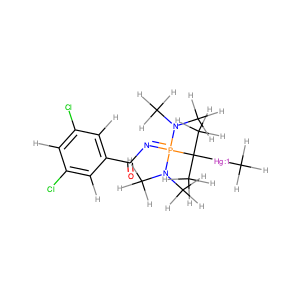

ProperTorsions
[H]C1=C(Cl)C([H])=C(C(=O)N=P(N(C([H])([H])[H])C([H])([H])[H])(N(C([H])([H])[H])C([H])([H])[H])[C:1](C([H])([H])[H])(C([H])([H])[H])[Hg:2][C:3]([H])([H])[H:4])C([H])=C1Cl


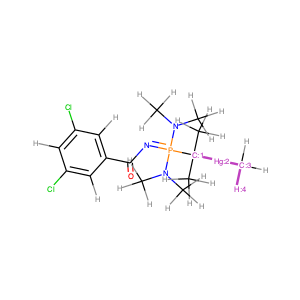

[H]C1=C(Cl)C([H])=C(C(=O)N=P(N(C([H])([H])[H])C([H])([H])[H])(N(C([H])([H])[H])C([H])([H])[H])[C:3](C([H])([H])[H])([Hg:2][C:1]([H])([H])[H])[C:4]([H])([H])[H])C([H])=C1Cl


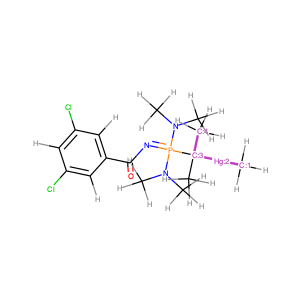

[H]C1=C(Cl)C([H])=C([C:1](=O)[N:2]=[P:3](N(C([H])([H])[H])C([H])([H])[H])(C([Hg]C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])[N:4](C([H])([H])[H])C([H])([H])[H])C([H])=C1Cl


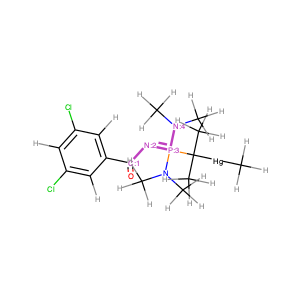

[H]C1=C(Cl)C([H])=C([C:4](=O)[N:3]=[P:2](N(C([H])([H])[H])C([H])([H])[H])(N(C([H])([H])[H])C([H])([H])[H])[C:1]([Hg]C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])C([H])=C1Cl


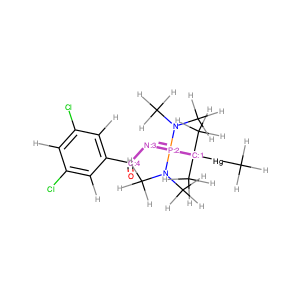

[H]C1=C(Cl)C([H])=C(C(=O)N=[P:4](N(C([H])([H])[H])C([H])([H])[H])(N(C([H])([H])[H])C([H])([H])[H])[C:3](C([H])([H])[H])(C([H])([H])[H])[Hg:2][C:1]([H])([H])[H])C([H])=C1Cl


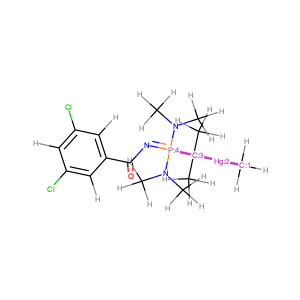

[H]C1=C(Cl)C([H])=C(C(=O)N=P(N(C([H])([H])[H])C([H])([H])[H])(N(C([H])([H])[H])C([H])([H])[H])[C:1](C([H])([H])[H])(C([H])([H])[H])[Hg:2][C:3]([H])([H])[H:4])C([H])=C1Cl


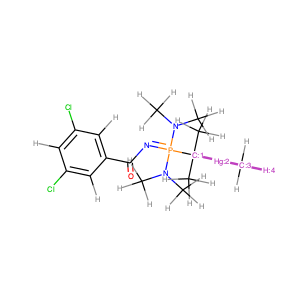

[H]C1=C(Cl)C([H])=C(C(=O)N=P(N(C([H])([H])[H])C([H])([H])[H])(N(C([H])([H])[H])C([H])([H])[H])[C:1](C([H])([H])[H])(C([H])([H])[H])[Hg:2][C:3]([H])([H])[H:4])C([H])=C1Cl


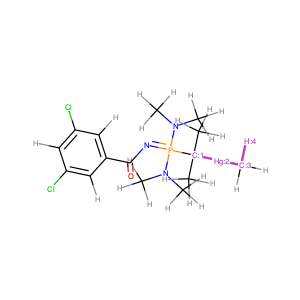

[H]C1=C(Cl)C([H])=C([C:1](=O)[N:2]=[P:3](N(C([H])([H])[H])C([H])([H])[H])(C([Hg]C([H])([H])[H])(C([H])([H])[H])C([H])([H])[H])[N:4](C([H])([H])[H])C([H])([H])[H])C([H])=C1Cl


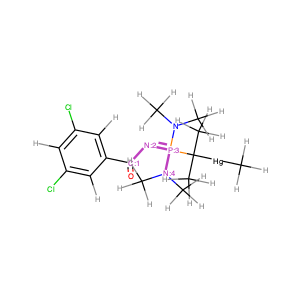

[H]C1=C(Cl)C([H])=C(C(=O)N=P(N(C([H])([H])[H])C([H])([H])[H])(N(C([H])([H])[H])C([H])([H])[H])[C:3](C([H])([H])[H])([Hg:2][C:1]([H])([H])[H])[C:4]([H])([H])[H])C([H])=C1Cl


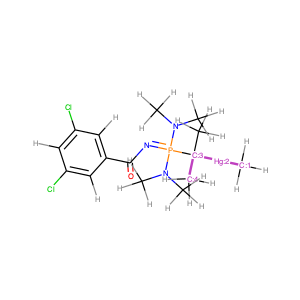

Angles
[H]C1=C(Cl)C([H])=C(C(=O)N=P(N(C([H])([H])[H])C([H])([H])[H])(N(C([H])([H])[H])C([H])([H])[H])[C:3](C([H])([H])[H])(C([H])([H])[H])[Hg:2][C:1]([H])([H])[H])C([H])=C1Cl


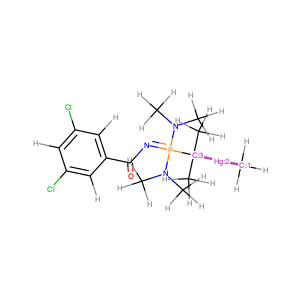

Bonds
[H]C1=C(Cl)C([H])=C(C(=O)N=P(N(C([H])([H])[H])C([H])([H])[H])(N(C([H])([H])[H])C([H])([H])[H])[C:2](C([H])([H])[H])(C([H])([H])[H])[Hg:1]C([H])([H])[H])C([H])=C1Cl


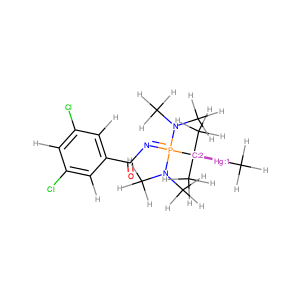

[H]C1=C(Cl)C([H])=C(C(=O)N=P(N(C([H])([H])[H])C([H])([H])[H])(N(C([H])([H])[H])C([H])([H])[H])C(C([H])([H])[H])(C([H])([H])[H])[Hg:2][C:1]([H])([H])[H])C([H])=C1Cl


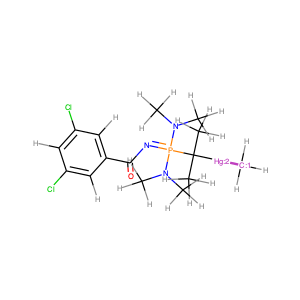

Processing "molecule_3" with smiles [H][C]1=[C]([H])[C]([H])=[C]([C]2=[C]3[N]=[C]([C]([H])([H])[H])[C]([H])=[C]([C]([H])([H])[H])[N+]3=[C]([S][C]([H])([H])[H])[S]2)[C]([H])=[C]1[H]
ProperTorsions
[H]C1=C([H])C([H])=C(C2=[C:1]3N=C(C([H])([H])[H])C([H])=C(C([H])([H])[H])[N+:2]3=[C:3](SC([H])([H])[H])[S:4]2)C([H])=C1[H]


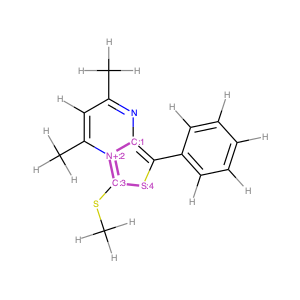

[H]C1=C([H])C([H])=C(C2=[C:1]3N=C(C([H])([H])[H])C([H])=C(C([H])([H])[H])[N+:2]3=[C:3]([S:4]C([H])([H])[H])S2)C([H])=C1[H]


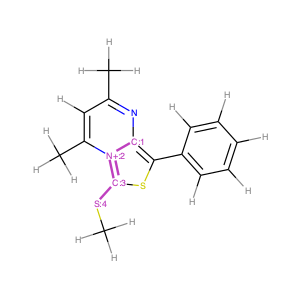

[H]C1=C([H])C([H])=C(C2=C3N=C(C([H])([H])[H])C([H])=[C:1](C([H])([H])[H])[N+:2]3=[C:3]([S:4]C([H])([H])[H])S2)C([H])=C1[H]


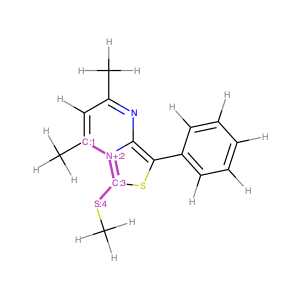

[H]C1=C([H])C([H])=C(C2=C3N=C(C([H])([H])[H])C([H])=[C:1](C([H])([H])[H])[N+:2]3=[C:3](SC([H])([H])[H])[S:4]2)C([H])=C1[H]


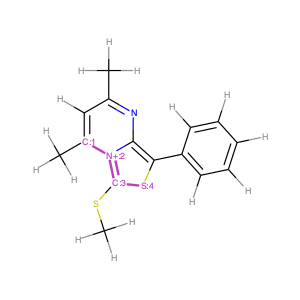

Processing "molecule_4" with smiles [H][C]([H])([O][P]1([O][C]([H])([H])[C]([H])([H])[C]([F])([F])[F])=[N][P]([O][C]([H])([H])[C]([H])([H])[C]([F])([F])[F])([O][C]([H])([H])[C]([H])([H])[C]([F])([F])[F])=[N][P]([O][C]([H])([H])[C]([H])([H])[C]([F])([F])[F])([O][C]([H])([H])[C]([H])([H])[C]([F])([F])[F])=[N]1)[C]([H])([H])[C]([F])([F])[F]
ProperTorsions
[H]C([H])(OP1(OC([H])([H])C([H])([H])C(F)(F)F)=N[P:3](OC([H])([H])C([H])([H])C(F)(F)F)([O:4]C([H])([H])C([H])([H])C(F)(F)F)=[N:2][P:1](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=N1)C([H])([H])C(F)(F)F


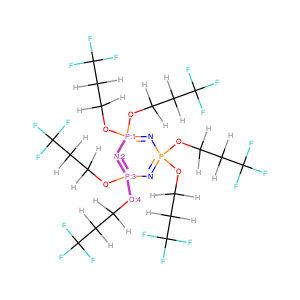

[H]C([H])(OP1(OC([H])([H])C([H])([H])C(F)(F)F)=N[P:3](OC([H])([H])C([H])([H])C(F)(F)F)([O:4]C([H])([H])C([H])([H])C(F)(F)F)=[N:2][P:1](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=N1)C([H])([H])C(F)(F)F


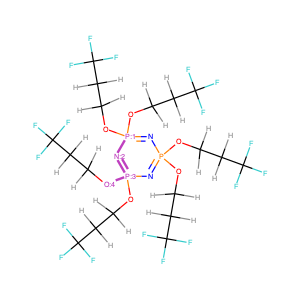

[H]C([H])(OP1(OC([H])([H])C([H])([H])C(F)(F)F)=[N:4][P:3](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=[N:2][P:1](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=N1)C([H])([H])C(F)(F)F


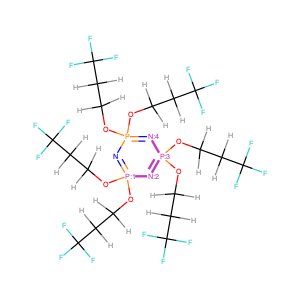

[H]C([H])(OP1(OC([H])([H])C([H])([H])C(F)(F)F)=[N:4][P:3](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=[N:2][P:1](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=N1)C([H])([H])C(F)(F)F


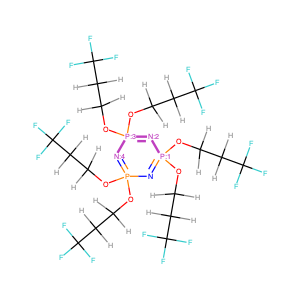

[H]C([H])(OP1(OC([H])([H])C([H])([H])C(F)(F)F)=N[P:1](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=[N:2][P:3](OC([H])([H])C([H])([H])C(F)(F)F)([O:4]C([H])([H])C([H])([H])C(F)(F)F)=N1)C([H])([H])C(F)(F)F


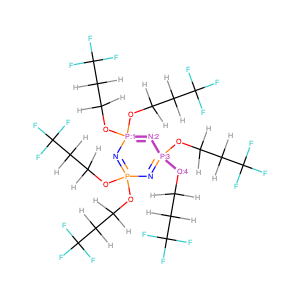

[H]C([H])(OP1(OC([H])([H])C([H])([H])C(F)(F)F)=N[P:1](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=[N:2][P:3](OC([H])([H])C([H])([H])C(F)(F)F)([O:4]C([H])([H])C([H])([H])C(F)(F)F)=N1)C([H])([H])C(F)(F)F


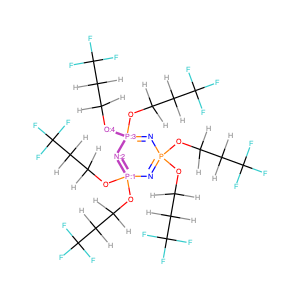

[H]C([H])(OP1(OC([H])([H])C([H])([H])C(F)(F)F)=N[P:1](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=[N:2][P:3](OC([H])([H])C([H])([H])C(F)(F)F)([O:4]C([H])([H])C([H])([H])C(F)(F)F)=N1)C([H])([H])C(F)(F)F


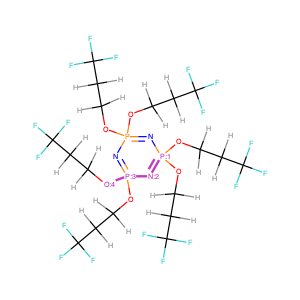

[H]C([H])(OP1(OC([H])([H])C([H])([H])C(F)(F)F)=N[P:3](OC([H])([H])C([H])([H])C(F)(F)F)([O:4]C([H])([H])C([H])([H])C(F)(F)F)=[N:2][P:1](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=N1)C([H])([H])C(F)(F)F


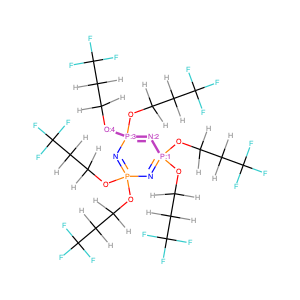

[H]C([H])(OP1(OC([H])([H])C([H])([H])C(F)(F)F)=N[P:1](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=[N:2][P:3](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=[N:4]1)C([H])([H])C(F)(F)F


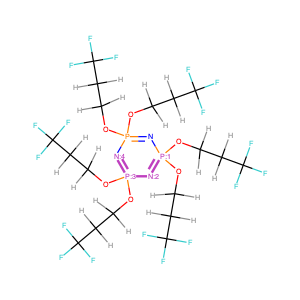

[H]C([H])(OP1(OC([H])([H])C([H])([H])C(F)(F)F)=N[P:4](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=[N:3][P:2](OC([H])([H])C([H])([H])C(F)(F)F)([O:1]C([H])([H])C([H])([H])C(F)(F)F)=N1)C([H])([H])C(F)(F)F


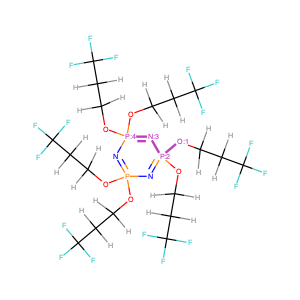

[H]C([H])(OP1(OC([H])([H])C([H])([H])C(F)(F)F)=N[P:4](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=[N:3][P:2](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=[N:1]1)C([H])([H])C(F)(F)F


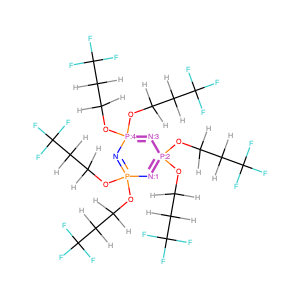

[H]C([H])(OP1(OC([H])([H])C([H])([H])C(F)(F)F)=N[P:3](OC([H])([H])C([H])([H])C(F)(F)F)([O:4]C([H])([H])C([H])([H])C(F)(F)F)=[N:2][P:1](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=N1)C([H])([H])C(F)(F)F


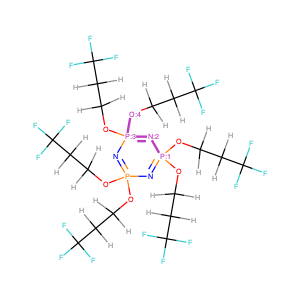

[H]C([H])(OP1(OC([H])([H])C([H])([H])C(F)(F)F)=N[P:1](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=[N:2][P:3](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=[N:4]1)C([H])([H])C(F)(F)F


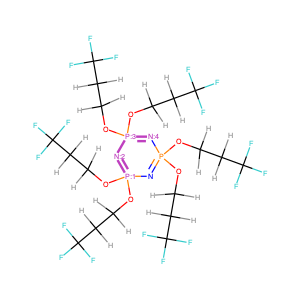

[H]C([H])(OP1(OC([H])([H])C([H])([H])C(F)(F)F)=N[P:2](OC([H])([H])C([H])([H])C(F)(F)F)([O:1]C([H])([H])C([H])([H])C(F)(F)F)=[N:3][P:4](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=N1)C([H])([H])C(F)(F)F


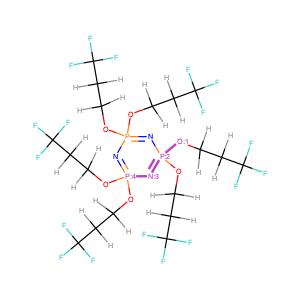

[H]C([H])(OP1(OC([H])([H])C([H])([H])C(F)(F)F)=N[P:1](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=[N:2][P:3](OC([H])([H])C([H])([H])C(F)(F)F)([O:4]C([H])([H])C([H])([H])C(F)(F)F)=N1)C([H])([H])C(F)(F)F


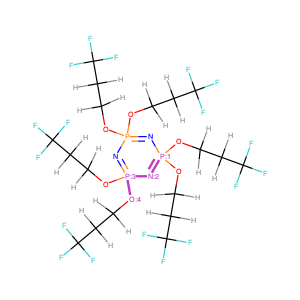

[H]C([H])(OP1(OC([H])([H])C([H])([H])C(F)(F)F)=N[P:1](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=[N:2][P:3](OC([H])([H])C([H])([H])C(F)(F)F)([O:4]C([H])([H])C([H])([H])C(F)(F)F)=N1)C([H])([H])C(F)(F)F


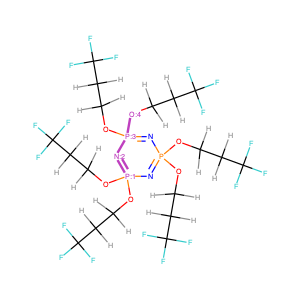

[H]C([H])(OP1(OC([H])([H])C([H])([H])C(F)(F)F)=N[P:3](OC([H])([H])C([H])([H])C(F)(F)F)([O:4]C([H])([H])C([H])([H])C(F)(F)F)=[N:2][P:1](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=N1)C([H])([H])C(F)(F)F


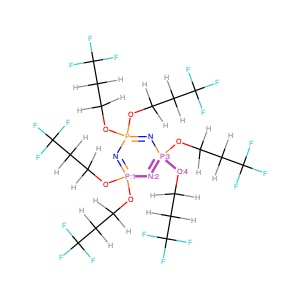

[H]C([H])(OP1(OC([H])([H])C([H])([H])C(F)(F)F)=[N:1][P:2](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=[N:3][P:4](OC([H])([H])C([H])([H])C(F)(F)F)(OC([H])([H])C([H])([H])C(F)(F)F)=N1)C([H])([H])C(F)(F)F


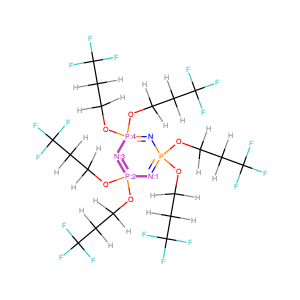

In [35]:
forcefield = ForceField('smirnoff99Frosst-1.1.0.offxml')

results = {}

for mol_idx, molecule in enumerate(molecules):
    # Prepare a title for this molecule
    if molecule.name is '':
        mol_name = f'molecule_{mol_idx}'
    else:
        mol_name = molecule.name
    print(f'Processing "{mol_name}" with smiles {molecule.to_smiles()}')
    
    # Analyze missing parameters
    missing_params = report_missing_parameters(molecule, forcefield)
    results[mol_name] = missing_params
    for tagname, missing_tag_params in missing_params.items():
        print(tagname)
        for missing_param in missing_tag_params:
            print(missing_param['tagged_smiles'])
            display(missing_param['image'])



## Write a report of parametrization failures

Since the results from above are only stored as data in this Python session, it can be helpful to save a more permanent representation of these results to disk. 

First, we install a PDF-generation tool called `reportlab`. Note that you'll only need to do this once.

In [37]:
! pip install reportlab

In [36]:
from reportlab.pdfgen import canvas
from reportlab.platypus import SimpleDocTemplate, KeepTogether, Paragraph
from reportlab.platypus.flowables import Image
from reportlab.lib.styles import getSampleStyleSheet
import os
from io import BytesIO

styles = getSampleStyleSheet()

for mol_name, result_dict in results.items():
    if result_dict == {}:
        continue
    if not os.path.exists(mol_name):
        os.mkdir(mol_name)
    for tagname, missing_parm_dicts in result_dict.items():
        output_file = os.path.join(mol_name, f"{tagname}.pdf")
        elements = []
        #print(help())
        for missing_parm_dict in missing_parm_dicts:
            smiles_formatted = Paragraph(missing_parm_dict['tagged_smiles'], 
                                         styles["Normal"])
            
            # reportlab can't load PIL objects, so wo have to make the 
            # image look like a file buffer
            img_bytesio = BytesIO()
            missing_parm_dict['image'].save(img_bytesio, 'PNG')
            img_bytesio.seek(0)
            img_formatted = Image(img_bytesio)
            elements.append(KeepTogether([smiles_formatted, img_formatted]))
        doc = SimpleDocTemplate(output_file)
        doc.build(elements)
